<a href="https://colab.research.google.com/github/CristinaMarsh/Learning_/blob/main/Stool/Neuralforecast_learning_models_esrnn__mqesrnn_and_datasetpre_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#source: https://github.com/Nixtla/neuralforecast/blob/main/nbs/models_esrnn__mqesrnn.ipynb


! git clone https://github.com/Nixtla/neuralforecast.git

Cloning into 'neuralforecast'...
remote: Enumerating objects: 5197, done.
remote: Counting objects: 100% (358/358), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 5197 (delta 224), reused 259 (delta 165), pack-reused 4839
Receiving objects: 100% (5197/5197), 28.29 MiB | 26.70 MiB/s, done.
Resolving deltas: 100% (3648/3648), done.


In [2]:
%cd neuralforecast/

/content/neuralforecast


In [3]:
! pip install neuralforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 138 kB 15.1 MB/s 
     |████████████████████████████████| 585 kB 56.8 MB/s 
     |████████████████████████████████| 65 kB 3.6 MB/s 
     |████████████████████████████████| 140 kB 67.5 MB/s 
     |████████████████████████████████| 596 kB 64.7 MB/s 
     |████████████████████████████████| 419 kB 61.9 MB/s 
     |████████████████████████████████| 1.1 MB 60.6 MB/s 
     |████████████████████████████████| 271 kB 70.5 MB/s 
     |████████████████████████████████| 144 kB 63.4 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 50 kB 8.0 MB/s 
     |████████████████████████████████| 2.4 MB 21.6 MB/s 
     |████████████████████████████████| 94 kB 3.9 MB/s 
     |████████████████████████████████| 357 kB 74.1 MB/s 
     |████████████████████████████████| 2.3 MB 57.5 MB/s 
     |████████████████████████████████|

In [4]:
from typing import List

from neuralforecast.models.esrnn.esrnn import ESRNN

In [5]:
# export
class MQESRNN(ESRNN):
    def __init__(self,
                 n_series: int,
                 input_size: int,
                 output_size: int,
                 n_x: int = 0,
                 n_s: int = 0,
                 sample_freq: int = 1,
                 es_component: str = 'median_residual',
                 cell_type: str = 'LSTM',
                 state_hsize: int = 50,
                 dilations: List[List[int]] = [[1, 2], [4, 8]],
                 add_nl_layer: bool = False,
                 learning_rate: float = 1e-3,
                 lr_scheduler_step_size: int = 9,
                 lr_decay: float = 0.9,
                 gradient_eps: float = 1e-8,
                 gradient_clipping_threshold: float = 20.,
                 rnn_weight_decay: float = 0.,
                 noise_std: float = 1e-3,
                 testing_percentiles: List[float] = [2.5, 5., 50., 95., 97.5],
                 training_percentiles: List[float] = [2.5, 5., 50., 95., 97.5],
                 loss: str = 'MQ',
                 val_loss: str = 'MQ',
                 frequency: str = 'D'):
        """ Multi-Quantile Exponential Smoothing Recurrent Neural Network
    
        Parameters
        ----------
        n_series: int
            Number of time series.
        n_x: int
            Number of temporal exogenous variables.
        n_s: int
            Number of static variables.
        input_size: int
            input size of the recurrent neural network, usually a
            multiple of seasonality
        output_size: int
            output_size or forecast horizon of the recurrent neural
            network, usually multiple of seasonality
        sample_freq: int
            Step size between windows.
        es_component: str
            Exponential Smoothing component.
            Default multiplicative.
        cell_type: str
            Type of RNN cell, available GRU, LSTM, RNN, ResidualLSTM.
        state_hsize: int
            dimension of hidden state of the recurrent neural network
        dilations: int list
            each list represents one chunk of Dilated LSTMS, connected in
            standard ResNet fashion
        add_nl_layer: bool
            whether to insert a tanh() layer between the RNN stack and the
            linear adaptor (output) layers
        learning_rate: float
            size of the stochastic gradient descent steps
        lr_scheduler_step_size: int
            this step_size is the period for each learning rate decay
        lr_decay: float
            Learning rate decay.
        per_series_lr_multip: float
            multiplier for per-series parameters smoothing and initial
            seasonalities learning rate (default 1.0)
        gradient_eps: float
            term added to the Adam optimizer denominator to improve
            numerical stability (default: 1e-8)
        gradient_clipping_threshold: float
            max norm of gradient vector, with all parameters treated
            as a single vector
        rnn_weight_decay: float
            parameter to control classic L2/Tikhonov regularization
            of the rnn parameters
        noise_std: float
            standard deviation of white noise added to input during
            fit to avoid the model from memorizing the train data
        level_variability_penalty: float
            this parameter controls the strength of the penalization
            to the wigglines of the level vector, induces smoothness
            in the output
        testing_percentiles: List[float]
            This values are only for diagnostic evaluation.
        training_percentiles: List[float]
            Percentiles to train and forecast.
        loss: str
            Loss used to train.
            Available: 'MQ', 'wMQ'.
        val_loss: str
            Loss used to validate.
            Available: 'MQ', 'wMQ'.
        frequency: str
            Time series frequency.
        
        Notes
        -----
        **References:**
        `Application
        <https://arxiv.org/abs/2112.05673`__
        """
        
        allowed_losses = ['MQ', 'wMQ']
        if loss not in allowed_losses:
            raise Exception(f'Loss {loss} not allowed')
            
        if val_loss is not None and val_loss not in allowed_losses:
            raise Exception(f'Val loss {val_loss} not allowed')
        
        allowed_es_component = ['median_residual', 'identity']
        
        if es_component not in allowed_es_component:
            raise Exception(f'es component {es_component} not allowed')
        
        level_variability_penalty = 0
        seasonality = []
        per_series_lr_multip = 1
        super(MQESRNN, self).__init__(n_series=n_series,
                                      n_s=n_s,
                                      n_x=n_x,
                                      sample_freq=sample_freq,
                                      input_size=input_size,
                                      output_size=output_size,
                                      es_component=es_component,
                                      cell_type=cell_type,
                                      state_hsize=state_hsize,
                                      dilations=dilations,
                                      add_nl_layer=add_nl_layer,
                                      seasonality=seasonality,
                                      learning_rate=learning_rate,
                                      lr_scheduler_step_size=lr_scheduler_step_size,
                                      lr_decay=lr_decay,
                                      per_series_lr_multip=per_series_lr_multip,
                                      gradient_eps=gradient_eps,
                                      gradient_clipping_threshold=gradient_clipping_threshold,
                                      rnn_weight_decay=rnn_weight_decay,
                                      noise_std=noise_std,
                                      level_variability_penalty=level_variability_penalty,
                                      testing_percentile=testing_percentiles,
                                      training_percentile=training_percentiles,
                                      loss=loss,
                                      val_loss=val_loss,
                                      frequency=frequency)

## Tests MQESRNN

In [6]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch as t

from neuralforecast.data.tsdataset import TimeSeriesDataset
from neuralforecast.data.tsloader import TimeSeriesLoader

In [7]:

n_ds = 100
n_ts = 1_000

output_size = 10

uids = [f'uid_{i+1}' for i in range(n_ts)]
dss = pd.date_range(end='2020-01-01', periods=n_ds)

Y_df = pd.DataFrame({'unique_id': np.repeat(uids, n_ds), 'ds': np.tile(dss, n_ts)})

In [8]:
np.random.seed(10)
Y_df['y'] = Y_df.groupby('unique_id').transform(lambda x: np.random.uniform(1, 100, size=len(x)))

In [9]:
Y_df = Y_df.sort_values(['unique_id', 'ds'])

In [11]:
Y_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99899
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   unique_id  100000 non-null  object        
 1   ds         100000 non-null  datetime64[ns]
 2   y          100000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 3.1+ MB


In [12]:
Y_df.unique_id.value_counts() # N_s, Number of static variables. 100. same

uid_1      100
uid_702    100
uid_691    100
uid_692    100
uid_693    100
          ... 
uid_402    100
uid_403    100
uid_404    100
uid_405    100
uid_999    100
Name: unique_id, Length: 1000, dtype: int64

In [13]:
Y_df.head()

,unique_id,ds,y
0,uid_1,2019-09-24,77.360744
1,uid_1,2019-09-25,3.054443
2,uid_1,2019-09-26,63.731175
3,uid_1,2019-09-27,75.131584
4,uid_1,2019-09-28,50.352194


In [14]:
train_dataset = TimeSeriesDataset(Y_df=Y_df,
                                  ds_in_test=3*output_size,#? # Only used when mask_df = None. Numer of datestamps to use as outsample.
                                  is_test=False,
                                  input_size=7*output_size,
                                  output_size=output_size,
                                  verbose=True)

valid_dataset = TimeSeriesDataset(Y_df=Y_df,
                                  input_size=7*output_size,
                                  output_size=output_size,
                                  verbose=False)

INFO:root:Train Validation splits

INFO:root:                    ds           
                   min        max
sample_mask                      
0           2019-12-03 2020-01-01
1           2019-09-24 2019-12-02
INFO:root:
Total data 			100000 time stamps 
Available percentage=100.0, 	100000 time stamps 
Insample  percentage=70.0, 	70000 time stamps 
Outsample percentage=30.0, 	30000 time stamps 



In [17]:
train_loader = TimeSeriesLoader(dataset=train_dataset,
                                batch_size=32,
                                eq_batch_size=True,
                                shuffle=True)

valid_loader = TimeSeriesLoader(dataset=valid_dataset,
                                batch_size=32,
                                shuffle=False)

In [18]:
model = MQESRNN(n_series=train_dataset.n_series,
                n_s=train_dataset.n_s,
                n_x=train_dataset.n_x,
                #sample_freq=dataset.sample_freq,
                sample_freq=1,
                input_size=7*2,
                output_size=output_size,
                learning_rate=1e-2,
                lr_scheduler_step_size=30,
                lr_decay=0.1,
                gradient_eps=1e-8,
                gradient_clipping_threshold=10,
                rnn_weight_decay=0,
                noise_std=0.001,
                testing_percentiles=[30, 50, 70, 90],
                training_percentiles=[30, 50, 70, 90],
                es_component='median_residual',
                cell_type='LSTM',
                state_hsize=100,
                dilations=[[1, 2], [4, 8]],
                add_nl_layer=False,
                loss='MQ',
                val_loss='MQ')

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmppbyyzbht
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmppbyyzbht/_remote_module_non_sriptable.py


In [19]:

trainer = pl.Trainer(max_epochs=1, progress_bar_refresh_rate=5, deterministic=True)
trainer.fit(model, train_loader, valid_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=5)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1817: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
Missing logger folder: /content/neuralforecast/lightn

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [20]:
outputs = trainer.predict(model, valid_loader)

Predicting: 32it [00:00, ?it/s]

In [21]:
y_true, y_hat, mask = zip(*outputs)
y_true = t.cat(y_true).numpy()
y_hat = t.cat(y_hat).numpy()
mask = t.cat(mask).numpy()

In [22]:
y_true = y_true[-1000:, -1]
y_hat = y_hat[-1000:, -1]

calibration p30:  0.3233
calibration p50:  0.507
calibration p70:  0.6962
calibration p90:  0.9519


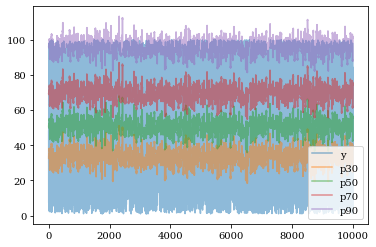

In [23]:
plt.plot(y_true.flatten(), alpha=0.5, label='y')
for idx, p in enumerate([30, 50, 70, 90]):
    y_p = y_hat[:, :, idx]
    plt.plot(y_p.flatten(), alpha=0.5, label=f'p{p}')
    print(f'calibration p{p}: ', (y_true.flatten() <= y_p.flatten()).mean())
plt.legend()

In [24]:
forecast = model.forecast(Y_df, batch_size=128)

INFO:root:Train Validation splits

INFO:root:                    ds           
                   min        max
sample_mask                      
0           2019-09-24 2020-01-01
1           2020-01-02 2020-01-11
INFO:root:
Total data 			110000 time stamps 
Available percentage=100.0, 	110000 time stamps 
Insample  percentage=9.09, 	10000 time stamps 
Outsample percentage=90.91, 	100000 time stamps 

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` 

Predicting: 0it [00:00, ?it/s]

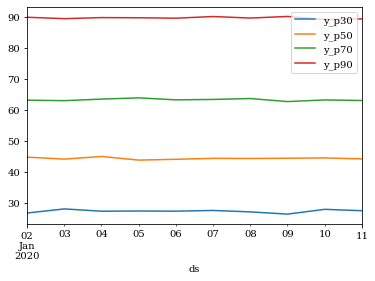

In [25]:
forecast.query('unique_id == "uid_1"').set_index('ds').plot()

# Dataset

## Base Dataset
Transforms pandas DataFrame into a TimeSeriesDataset for the Dataloder.

In [26]:
#export
import gc
import logging
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
import torch as t
from fastcore.foundation import patch
from torch.utils.data import Dataset
from datetime import datetime
from datetime import timedelta

In [27]:
#export
class BaseDataset(Dataset):
    """
    A class used to store Time Series data.
    """
    
    def __init__(self,
                 Y_df: pd.DataFrame,
                 X_df: Optional[pd.DataFrame] = None,
                 S_df: Optional[pd.DataFrame] = None,
                 f_cols: Optional[List] = None,
                 mask_df: Optional[pd.DataFrame] = None,
                 ds_in_test: int = 0,
                 is_test: bool = False,
                 input_size: int = None,
                 output_size: int = None,
                 complete_windows: bool = True,
                 scaler = None,
                 verbose: bool = False) -> 'BaseDataset':
        """
        Parameters
        ----------
        Y_df: pd.DataFrame
            Target time series with columns ['unique_id', 'ds', 'y'].
        X_df: pd.DataFrame
            Exogenous time series with columns ['unique_id', 'ds', 'y'].
        S_df: pd.DataFrame
            Static exogenous variables with columns ['unique_id', 'ds'] 
            and static variables.
        f_cols: list
            List of exogenous variables of the future.
        mask_df: pd.DataFrame
            Outsample mask with columns ['unique_id', 'ds', 'sample_mask']
            and optionally 'available_mask'.
            Default None: constructs default mask based on ds_in_test.
        ds_in_test: int
            Only used when mask_df = None.
            Numer of datestamps to use as outsample.
        is_test: bool
            Only used when mask_df = None.
            Wheter target time series belongs to test set.
        input_size: int
            Size of the training sets.
        output_size: int
            Forecast horizon.
        complete_windows: bool
            Whether consider only windows with sample_mask equal to output_size.
            Default False.
        verbose: bool
            Wheter or not log outputs.
        """        
        assert type(Y_df) == pd.core.frame.DataFrame
        assert all([(col in Y_df) for col in ['unique_id', 'ds', 'y']])
        self.verbose = verbose

        if X_df is not None:
            assert type(X_df) == pd.core.frame.DataFrame
            assert all([(col in X_df) for col in ['unique_id', 'ds']])
            assert len(Y_df)==len(X_df), 'The dimensions of Y_df and X_df are not the same'

        if mask_df is not None:
            assert len(Y_df)==len(mask_df), 'The dimensions of Y_df and mask_df are not the same'
            assert all([(col in mask_df) for col in ['unique_id', 'ds', 'sample_mask']])
            if 'available_mask' not in mask_df.columns:
                if self.verbose: 
                    logging.info('Available mask not provided, defaulted with 1s.')
                mask_df['available_mask'] = 1
            assert np.sum(np.isnan(mask_df.available_mask.values)) == 0
            assert np.sum(np.isnan(mask_df.sample_mask.values)) == 0
        else:
            mask_df = get_default_mask_df(Y_df=Y_df, 
                                          is_test=is_test,
                                          ds_in_test=ds_in_test)
        
        n_ds  = len(mask_df)
        n_avl = mask_df.available_mask.sum()        
        n_ins = mask_df.sample_mask.sum()
        n_out = len(mask_df) - mask_df.sample_mask.sum()

        avl_prc = np.round((100 * n_avl) / n_ds, 2)
        ins_prc = np.round((100 * n_ins) / n_ds, 2)
        out_prc = np.round((100 * n_out) / n_ds, 2)
        if self.verbose:
            logging.info('Train Validation splits\n')
            if len(mask_df.unique_id.unique()) < 10:
                logging.info(mask_df.groupby(['unique_id', 'sample_mask']).agg({'ds': ['min', 'max']}))
            else:
                logging.info(mask_df.groupby(['sample_mask']).agg({'ds': ['min', 'max']}))
            dataset_info  = f'\nTotal data \t\t\t{n_ds} time stamps \n'
            dataset_info += f'Available percentage={avl_prc}, \t{n_avl} time stamps \n'
            dataset_info += f'Insample  percentage={ins_prc}, \t{n_ins} time stamps \n'
            dataset_info += f'Outsample percentage={out_prc}, \t{n_out} time stamps \n'
            logging.info(dataset_info)
 
        self.ts_data, self.s_matrix, self.meta_data, self.t_cols, self.s_cols, self.ds \
                         = self._df_to_lists(Y_df=Y_df, S_df=S_df, X_df=X_df, mask_df=mask_df)

        # Dataset attributes
        self.n_series = len(self.ts_data)
        self.max_len = max([len(ts) for ts in self.ts_data])
        self.n_channels = len(self.t_cols) # t_cols insample_mask and outsample_mask
        self.frequency = pd.infer_freq(Y_df.head()['ds'])
        self.f_cols = f_cols
        self.f_idxs = self._get_f_idxs(f_cols) if f_cols else []
        self.input_size = input_size
        self.output_size = output_size
        self.complete_windows = complete_windows
        self.first_ds = 0

        # Number of X and S features
        self.n_x = 0 if X_df is None else X_df.shape[1] - 2 # -2 for unique_id and ds
        self.n_s = 0 if S_df is None else S_df.shape[1] - 1 # -1 for unique_id

        # Balances panel and creates 
        # numpy  s_matrix of shape (n_series, n_s)
        # numpy ts_tensor of shape (n_series, n_channels, max_len) n_channels = t_cols + masks
        self.len_series, self.ts_tensor = self._create_tensor()
        
        # Normalization
        self.scaler = scaler
        if self.scaler is not None:
            self.ts_tensor = self._scale_tensor(ts_tensor=self.ts_tensor)

        
        # Defining sampleable time series
        self.ts_idxs = np.arange(self.n_series)
        self.sampleable_ts_idxs: np.ndarray
        self.n_sampleable_ts: int
            
        self._define_sampleable_ts_idxs()

In [28]:
#export
@patch
def _define_sampleable_ts_idxs(self: BaseDataset) -> None:
    self.n_sampleable_ts = len(self.ts_tensor)
    self.sampleable_ts_idxs = self.ts_idxs.copy()

In [29]:
#export
@patch
def _df_to_lists(self: BaseDataset, 
                 S_df: pd.DataFrame,
                 Y_df: pd.DataFrame,
                 X_df: pd.DataFrame, 
                 mask_df: pd.DataFrame) -> Tuple[List[np.ndarray], 
                                                 List[np.ndarray],
                                                 List[np.ndarray], 
                                                 List[str],
                                                 List[str]]:
    """Transforms input dataframes to lists.

    Parameters
    ----------
    S_df: pd.DataFrame
        Static exogenous variables with columns ['unique_id', 'ds'] 
        and static variables.    
    Y_df: pd.DataFrame
        Target time series with columns ['unique_id', 'ds', 'y'].
    X_df: pd.DataFrame
        Exogenous time series with columns ['unique_id', 'ds', 'y'].
    mask_df: pd.DataFrame
        Outsample mask with columns ['unique_id', 'ds', 'sample_mask']
        and optionally 'available_mask'.
        Default None: constructs default mask based on ds_in_test.

    Returns
    -------
    Tuple of five lists:
        - List of time series. Each element of the list is a 
          numpy array of shape (length of the time series, n_channels),
          where n_channels = t_cols + masks.
        - List of static variables. Each element of the list is a 
          numpy array of shape (1, n_s).
          where n_channels = t_cols + masks.
        - List of meta data. Each element of the list is a 
          numpy array of shape (lenght of the time series, 2) 
          and corresponds to unique_id, ds.
        - List of temporal variables (including target and masks). 
        - List of statitc variables.
    """
    # None protections
    if X_df is None:
        X_df = Y_df[['unique_id', 'ds']]
    
    if S_df is None:
        S_df = Y_df[['unique_id']].drop_duplicates()
    
    # Protect order of data
    Y = Y_df.sort_values(by=['unique_id', 'ds'], ignore_index=True).copy()
    X = X_df.sort_values(by=['unique_id', 'ds'], ignore_index=True).copy()
    M = mask_df.sort_values(by=['unique_id', 'ds'], ignore_index=True).copy()
    
    assert np.array_equal(X.unique_id.values, Y.unique_id.values), f'Mismatch in X, Y unique_ids'
    assert np.array_equal(X.ds.values, Y.ds.values), f'Mismatch in X, Y ds'
    assert np.array_equal(M.unique_id.values, Y.unique_id.values), f'Mismatch in M, Y unique_ids'
    assert np.array_equal(M.ds.values, Y.ds.values), f'Mismatch in M, Y ds'

    # Dates
    ds = np.sort(Y['ds'].unique())
    
    # Create bigger grouped by dataframe G to parse
    M = M[['available_mask', 'sample_mask']]
    X.drop(labels=['unique_id', 'ds'], axis=1, inplace=True)
    G = Y.join(X).join(M)
    
    S = S_df.sort_values('unique_id')
    
    # time columns and static columns for future indexing
    t_cols = [col for col in G.columns if col not in ['unique_id', 'ds']]# avoid unique_id and ds
    s_cols = [col for col in S.columns if col not in ['unique_id']] # avoid unique_id
    
    grouped = G.groupby('unique_id')
    meta = G[['unique_id', 'ds']].values
    data = G.drop(columns=['unique_id', 'ds']).values
    sizes = grouped.size()
    idxs = np.append(0, sizes.cumsum())
    ts_data = []
    meta_data = []
    for start, end in zip(idxs[:-1], idxs[1:]):
        ts_data.append(data[start:end])
        meta_data.append(meta[start:end])
        
    if S['unique_id'].value_counts().max() > 1:
        raise ValueError('Found duplicated unique_ids in S_df')
    s_data = S.drop(columns='unique_id').values
    
    del S, Y, X, M, G
    gc.collect()
    
    return ts_data, s_data, meta_data, t_cols, s_cols, ds

In [30]:
# export
@patch
def _create_tensor(self: BaseDataset) -> Tuple[np.array, t.Tensor]:
    """Transforms outputs from self._df_to_lists to numpy arrays."""
    ts_tensor = np.zeros((self.n_series, self.n_channels, self.max_len))

    len_series = np.empty(self.n_series, dtype=np.int32)
    for idx, ts_idx in enumerate(self.ts_data):
        # Left padded time series tensor
        ts_tensor[idx, :, -ts_idx.shape[0]:] = ts_idx.T
        len_series[idx] = ts_idx.shape[0]
    
    ts_tensor = t.Tensor(ts_tensor)

    return len_series, ts_tensor

In [31]:
# export
@patch
def _scale_tensor(self: BaseDataset, ts_tensor):
    """ Scale tensor """
    if self.scaler.fitted == False:
        mask = ts_tensor[:, self.t_cols.index('available_mask'), :] * \
               ts_tensor[:, self.t_cols.index('sample_mask'), :]

        self.scaler.fit(X=ts_tensor[:, :self.t_cols.index('available_mask'), :], mask=mask)

    ts_tensor[:, :self.t_cols.index('available_mask'), :] = \
        self.scaler.transform(ts_tensor[:, :self.t_cols.index('available_mask'), :])

    return ts_tensor

In [32]:
#export
@patch
def _get_f_idxs(self: BaseDataset, 
               cols: List[str]) -> List:
    """Gets indexes of exogenous variables.

    Parameters
    ----------
    cols: List[str]
        Interest exogenous variables.

    Returns
    -------
    Indexes of cols variables.
    """
    # Check if cols are available f_cols and return the idxs
    if not all(col in self.f_cols for col in cols):
        str_cols = ', '.join(cols)
        raise Exception(f'Some variables in {str_cols} are not available in f_cols.')
    
    f_idxs = [self.t_cols.index(col) for col in cols]

    return f_idxs

In [33]:
#export
@patch
def __getitem__(self: BaseDataset, 
                idx: Union[slice, int]) -> Dict[str, t.Tensor]:
    """Creates batch based on index.
    
    Parameters
    ----------
    index: np.ndarray
        Indexes of time series to consider.
    
    Returns
    -------
    Dictionary with keys:
        - S
        - Y
        - X
        - available_mask
        - sample_mask
        - idxs
    """
    # Checks for idx
    pass

In [34]:
#export
@patch
def __len__(self: BaseDataset):
    return self.n_series

In [35]:
#export
@patch
def get_n_variables(self: BaseDataset) -> Tuple[int, int]:
    """Gets number of exogenous and static variables."""
    return self.n_x, self.n_s

@patch
def get_n_series(self: BaseDataset) -> int:
    """Gets number of time series."""
    return self.n_series

@patch
def get_max_len(self: BaseDataset) -> int:
    """Gets max len of time series."""
    return self.max_len

@patch
def get_n_channels(self: BaseDataset) -> int:
    """Gets number of channels considered."""
    return self.n_channels

@patch
def get_frequency(self: BaseDataset) -> str:
    """Gets infered frequency."""
    return self.frequency

In [36]:
#export
def get_default_mask_df(Y_df: pd.DataFrame, 
                        ds_in_test: int, 
                        is_test: bool) -> pd.DataFrame:
    """Constructs default mask df.

    Parameters
    ----------
    Y_df: pd.DataFrame
        Target time series with columns ['unique_id', 'ds', 'y'].
    ds_in_test: int
        Numer of datestamps to use as outsample.
    is_test: bool
        Wheter target time series belongs to test set.

    Returns
    -------
    Mask DataFrame with columns 
    ['unique_id', 'ds', 'available_mask', 'sample_mask'].
    """
    mask_df = Y_df[['unique_id', 'ds']].copy()
    mask_df['available_mask'] = 1
    mask_df['sample_mask'] = 1
    mask_df = mask_df.set_index(['unique_id', 'ds'])
    
    mask_df_s = mask_df.sort_values(by=['unique_id', 'ds'])
    zero_idx = mask_df_s.groupby('unique_id').tail(ds_in_test).index
    mask_df.loc[zero_idx, 'sample_mask'] = 0
    mask_df = mask_df.reset_index()
    mask_df.index = Y_df.index

    assert len(mask_df)==len(Y_df), \
        f'The mask_df length {len(mask_df)} is not equal to Y_df length {len(Y_df)}'

    if is_test:
        mask_df['sample_mask'] = 1 - mask_df['sample_mask']

    return mask_df

## TimeSeries Dataset

In [37]:
#export
class TimeSeriesDataset(BaseDataset):
    """
    A class used to store Time Series data.
    Each element is a windows index.
    Returns a windows for all time series.
    """
    
    def __init__(self,
                 Y_df: pd.DataFrame,
                 input_size: int,
                 output_size: int,
                 X_df: Optional[pd.DataFrame] = None,
                 S_df: Optional[pd.DataFrame] = None,
                 f_cols: Optional[List] = None,
                 mask_df: Optional[pd.DataFrame] = None,
                 ds_in_test: int = 0,
                 is_test: bool = False, 
                 complete_windows: bool = True,
                 scaler = None,
                 verbose: bool = False) -> 'TimeSeriesDataset':
        """
        Parameters
        ----------
        Y_df: pd.DataFrame
            Target time series with columns ['unique_id', 'ds', 'y'].
        input_size: int
            Size of the training sets.
        output_size: int
            Forecast horizon.
        X_df: pd.DataFrame
            Exogenous time series with columns ['unique_id', 'ds', 'y'].
        S_df: pd.DataFrame
            Static exogenous variables with columns ['unique_id', 'ds'] 
            and static variables.
        f_cols: list
            List of exogenous variables of the future.
        mask_df: pd.DataFrame
            Outsample mask with columns ['unique_id', 'ds', 'sample_mask']
            and optionally 'available_mask'.
            Default None: constructs default mask based on ds_in_test.
        ds_in_test: int
            Only used when mask_df = None.
            Numer of datestamps to use as outsample.
        is_test: bool
            Only used when mask_df = None.
            Wheter target time series belongs to test set.
        verbose: bool
            Wheter or not log outputs.
        """        
        super(TimeSeriesDataset, self).__init__(Y_df=Y_df, input_size=input_size,
                                                output_size=output_size,
                                                X_df=X_df, S_df=S_df, f_cols=f_cols,
                                                mask_df=mask_df, ds_in_test=ds_in_test,
                                                is_test=is_test, complete_windows=complete_windows,
                                                scaler=scaler,
                                                verbose=verbose)

In [38]:
#export
@patch
def __getitem__(self: TimeSeriesDataset, 
                idx: Union[slice, int]) -> Dict[str, t.Tensor]:
    """Creates batch based on index.
    
    Parameters
    ----------
    index: np.ndarray
        Indexes of time series to consider.
    
    Returns
    -------
    Dictionary with keys:
        - S
        - Y
        - X
        - available_mask
        - sample_mask
        - idxs
    """
    # Checks for idx
    if isinstance(idx, int):
        idx = [idx]
    elif isinstance(idx, slice) or isinstance(idx, list):
        pass
    else:
        raise Exception('Use slices, int or list for getitem.')

    # Parse windows to elements of batch
    S = t.Tensor(self.s_matrix[idx])
    Y = self.ts_tensor[idx, self.t_cols.index('y'), :]
    X = self.ts_tensor[idx, (self.t_cols.index('y') + 1):self.t_cols.index('available_mask'), :]
    
    available_mask = self.ts_tensor[idx, self.t_cols.index('available_mask'), :]
    sample_mask = self.ts_tensor[idx, self.t_cols.index('sample_mask'), :]
    ts_idxs = t.as_tensor(idx, dtype=t.long)

    batch = {'S': S, 'Y': Y, 'X': X,
             'available_mask': available_mask,
             'sample_mask': sample_mask,
             'ts_idxs': ts_idxs}
    
    return batch

## IterateWindows Dataset

In [39]:
#export
class IterateWindowsDataset(BaseDataset):
    """
    A class used to store Time Series data.
    """
    
    def __init__(self,
                 Y_df: pd.DataFrame,
                 input_size: int,
                 output_size: int,
                 X_df: Optional[pd.DataFrame] = None,
                 S_df: Optional[pd.DataFrame] = None,
                 f_cols: Optional[List] = None,
                 mask_df: Optional[pd.DataFrame] = None,
                 ds_in_test: int = 0,
                 scaler = None,
                 is_test: bool = False,
                 verbose: bool = False) -> 'IterateWindowsDataset':
        """
        Parameters
        ----------
        Y_df: pd.DataFrame
            Target time series with columns ['unique_id', 'ds', 'y'].
        input_size: int
            Size of the training sets.
        output_size: int
            Forecast horizon.
        X_df: pd.DataFrame
            Exogenous time series with columns ['unique_id', 'ds', 'y'].
        S_df: pd.DataFrame
            Static exogenous variables with columns ['unique_id', 'ds'] 
            and static variables.
        f_cols: list
            List of exogenous variables of the future.
        mask_df: pd.DataFrame
            Outsample mask with columns ['unique_id', 'ds', 'sample_mask']
            and optionally 'available_mask'.
            Default None: constructs default mask based on ds_in_test.
        ds_in_test: int
            Only used when mask_df = None.
            Numer of datestamps to use as outsample.
        is_test: bool
            Only used when mask_df = None.
            Wheter target time series belongs to test set.
        verbose: bool
            Wheter or not log outputs.
        """        
        super(IterateWindowsDataset, self).__init__(Y_df=Y_df, input_size=input_size,
                                                    output_size=output_size,
                                                    X_df=X_df, S_df=S_df, f_cols=f_cols,
                                                    mask_df=mask_df, ds_in_test=ds_in_test,
                                                    is_test=is_test, complete_windows=True,
                                                    scaler=scaler,
                                                    verbose=verbose)

        self.first_sampleable_stamps = np.nonzero(self.ts_tensor[0, self.t_cols.index('sample_mask'), :])[0,0]
        self.sampleable_stamps = t.sum(self.ts_tensor[0, self.t_cols.index('sample_mask'), :]) # TODO: now it assumes mask is correct

        self.first_sampleable_stamps = int(self.first_sampleable_stamps.cpu().detach().numpy())
        self.sampleable_stamps = int(self.sampleable_stamps.cpu().detach().numpy())

In [40]:
#export
@patch
def __getitem__(self: IterateWindowsDataset, 
                idx: int) -> Dict[str, t.Tensor]:
    """Creates batch based on index.
    
    Parameters
    ----------
    idx:
        Index of windowß to consider.
    
    Returns
    -------
    Dictionary with keys:
        - S
        - Y
        - X
        - available_mask
        - sample_mask
        - idxs
    """
    # Checks for idx
    if not isinstance(idx, int):
        raise Exception('idx should be an integer')

    # Add first sampleable stamp and shift by input_size if possible (this will never happen during training)
    if self.first_sampleable_stamps + 1 > self.input_size:
        idx = idx + self.first_sampleable_stamps - self.input_size

    # Parse windows to elements of batch
    end = idx + self.input_size + self.output_size
    S = t.Tensor(self.s_matrix)
    Y = self.ts_tensor[:, self.t_cols.index('y'), idx:end]
    X = self.ts_tensor[:, (self.t_cols.index('y') + 1):self.t_cols.index('available_mask'), idx:end]
    
    available_mask = self.ts_tensor[:, self.t_cols.index('available_mask'), idx:end]
    sample_mask = self.ts_tensor[:, self.t_cols.index('sample_mask'), idx:end]
    ts_idxs = t.as_tensor(np.arange(self.n_series), dtype=t.long)

    batch = {'S': S, 'Y': Y, 'X': X,
             'available_mask': available_mask,
             'sample_mask': sample_mask,
             'ts_idxs': ts_idxs}
    
    return batch

In [41]:
#export
@patch
def __len__(self: IterateWindowsDataset):
    if self.first_sampleable_stamps + 1 > self.input_size:
        return self.sampleable_stamps - self.output_size + 1 # We take the input_size chunk from the beginning, if possible
    else:
        return self.sampleable_stamps - self.input_size - self.output_size + 1 

## Windows Dataset

In [42]:
#export
class WindowsDataset(BaseDataset):
    """
    A class used to store Time Series data.
    """
    
    def __init__(self,
                 Y_df: pd.DataFrame,
                 input_size: int,
                 output_size: int,
                 X_df: Optional[pd.DataFrame] = None,
                 S_df: Optional[pd.DataFrame] = None,
                 f_cols: Optional[List] = None,
                 mask_df: Optional[pd.DataFrame] = None,
                 ds_in_test: int = 0,
                 is_test: bool = False,
                 sample_freq: int = 1,
                 complete_windows: bool = False,
                 last_window: bool = False,
                 scaler = None,
                 verbose: bool = False) -> 'TimeSeriesDataset':
        """
        Parameters
        ----------
        Y_df: pd.DataFrame
            Target time series with columns ['unique_id', 'ds', 'y'].
        input_size: int
            Size of the training sets.
        output_size: int
            Forecast horizon.
        X_df: pd.DataFrame
            Exogenous time series with columns ['unique_id', 'ds', 'y'].
        S_df: pd.DataFrame
            Static exogenous variables with columns ['unique_id', 'ds'] 
            and static variables.
        f_cols: list
            List of exogenous variables of the future.
        mask_df: pd.DataFrame
            Outsample mask with columns ['unique_id', 'ds', 'sample_mask']
            and optionally 'available_mask'.
            Default None: constructs default mask based on ds_in_test.
        ds_in_test: int
            Only used when mask_df = None.
            Numer of datestamps to use as outsample.
        is_test: bool
            Only used when mask_df = None.
            Wheter target time series belongs to test set.
        last_window: bool
            Only used for forecast (test)
            Wheter the dataset will include only last window for each time serie.
        verbose: bool
            Wheter or not log outputs.
        """        
        super(WindowsDataset, self).__init__(Y_df=Y_df, input_size=input_size,
                                             output_size=output_size,
                                             X_df=X_df, S_df=S_df, f_cols=f_cols,
                                             mask_df=mask_df, ds_in_test=ds_in_test,
                                             is_test=is_test, complete_windows=complete_windows,
                                             scaler=scaler,
                                             verbose=verbose)
        # WindowsDataset parameters
        self.windows_size = self.input_size + self.output_size
        self.padding = (self.input_size, self.output_size)
        
        # WindowsDataset _df_to_lists end datestamp warning
        if len(self.ds) != (self.max_len+self.input_size+self.output_size):
            logging.warning(
                'WARNING: _df_to_lists function assumes that panel series share same '
                'end datestamp. \n This causes leakage during train and incorrect forecast dates.'
            )

        self.sample_freq = sample_freq
        self.last_window = last_window
        self.device = 'cuda' if t.cuda.is_available() else 'cpu'

In [43]:
#export
@patch
def _create_windows_tensor(self: WindowsDataset, 
                           idx: slice) -> Tuple[t.Tensor, t.Tensor, t.Tensor]:
    """Creates windows of size windows_size from
    the ts_tensor of the TimeSeriesDataset filtered by
    window_sampling_limit and ts_idxs. The step of each window
    is defined by idx_to_sample_freq.
    
    Parameters
    ----------
    index: slice
        Indexes of time series to consider.
    
    Returns
    -------
    Tuple of three elements:
        - Windows tensor of shape (windows, channels, input_size + output_size)
        - Static variables tensor of shape (windows * series, n_static)
        - Time Series indexes for each window.
    """
    # Default ts_idxs=ts_idxs sends all the data, otherwise filters series   
    tensor = self.ts_tensor[idx, :, self.first_ds:]

    padder = t.nn.ConstantPad1d(padding=self.padding, value=0)
    tensor = padder(tensor)

    # Creating rolling windows and 'flattens' them
    tensor = tensor.to(self.device)
    windows = tensor.unfold(dimension=-1, 
                            size=self.windows_size, 
                            step=self.sample_freq)
    # n_serie, n_channel, n_time, window_size -> n_serie, n_time, n_channel, window_size
    windows = windows.permute(0, 2, 1, 3)
    windows = windows.reshape(-1, self.n_channels, self.windows_size)
    
    # Broadcast s_matrix: This works because unfold in windows_tensor, orders: serie, time
    
    ts_idxs = self.ts_idxs[idx]
    n_ts = len(ts_idxs)
    windows_per_serie = len(windows) / n_ts
    
    ts_idxs = ts_idxs.repeat(repeats=windows_per_serie)
    s_matrix = self.s_matrix[idx]
    s_matrix = s_matrix.repeat(repeats=windows_per_serie, axis=0)
    
    s_matrix = t.Tensor(s_matrix)
    ts_idxs = t.as_tensor(ts_idxs, dtype=t.long)

    windows_idxs = self._get_sampleable_windows_idxs(ts_windows_flatten=windows,
                                                     ts_idxs=ts_idxs)

    # Raise error if nothing to sample from
    if not windows_idxs.size:
        raise Exception(
            f'Time Series {idx} are not sampleable. '
            'Check the data, masks, window_sampling_limit, '
            'input_size, output_size, masks.'
        )

    # Index the windows and s_matrix tensors of batch
    windows = windows[windows_idxs]
    s_matrix = s_matrix[windows_idxs]
    ts_idxs = ts_idxs[windows_idxs]

    return windows, s_matrix, ts_idxs

In [44]:
#export
@patch
#TODO: do we want complete? inputs seems irrelevant, NBEATS dont use it, for now is our only model
def _get_sampleable_windows_idxs(self: WindowsDataset, 
                                 ts_windows_flatten: t.Tensor,
                                 ts_idxs: t.Tensor) -> np.ndarray:
    """Gets indexes of windows that fulfills conditions.
    
    Parameters
    ----------
    ts_windows_flatten: t.Tensor
        Tensor of shape (windows, n_channels, windows_size)
    
    Returns
    -------
    Numpy array of indexes of ts_windows_flatten that 
    fulfills conditions.
    
    Notes
    -----
    """

    if self.last_window:
        _, idxs_counts = t.unique(ts_idxs, return_counts=True)
        last_idxs = idxs_counts.cumsum(0) - 1
        last_idxs = last_idxs.numpy()

        return last_idxs

    if self.complete_windows:
        sample_condition = ts_windows_flatten[:, self.t_cols.index('sample_mask'), -(self.output_size):]
        sample_condition = (sample_condition > 0) * 1 # Converts continuous sample_mask (with weights) to 0-1
        sample_condition = t.sum(sample_condition, axis=1)
        sample_condition = (sample_condition == self.output_size) * 1

    else:
        sample_condition = ts_windows_flatten[:, self.t_cols.index('sample_mask'), -self.output_size:]
        sample_condition = (sample_condition > 0) * 1 # Converts continuous sample_mask (with weights) to 0-1
        sample_condition = t.sum(sample_condition, axis=1)
        sample_condition = (sample_condition > 0) * 1

    sampling_idx = t.nonzero(sample_condition > 0)
    sampling_idx = sampling_idx.cpu().detach().numpy()
    sampling_idx = sampling_idx.flatten()
        
    return sampling_idx

In [45]:
#export
@patch
def __getitem__(self: WindowsDataset, 
                idx: Union[slice, int]) -> Dict[str, t.Tensor]:
    """Creates batch based on index.
    
    Parameters
    ----------
    index: np.ndarray
        Indexes of time series to consider.
    
    Returns
    -------
    Dictionary with keys:
        - S
        - Y
        - X
        - available_mask
        - sample_mask
        - idxs
    """
    # Checks for idx
    if isinstance(idx, int):
        idx = [idx]
    elif isinstance(idx, slice) or isinstance(idx, list):
        pass
    else:
        raise Exception('Use slices, int or list for getitem.')

    # Create windows for each sampled ts and sample random unmasked windows from each ts
    windows, S, ts_idxs = self._create_windows_tensor(idx=idx)

    # Parse windows to elements of batch
    Y = windows[:, self.t_cols.index('y'), :]
    X = windows[:, (self.t_cols.index('y') + 1):self.t_cols.index('available_mask'), :]
    available_mask = windows[:, self.t_cols.index('available_mask'), :]
    sample_mask = windows[:, self.t_cols.index('sample_mask'), :]

    batch = {'S': S, 'Y': Y, 'X': X,
             'available_mask': available_mask,
             'sample_mask': sample_mask,
             'ts_idxs': ts_idxs}
    
    return batch

## Default mask example and tests

In [46]:
def test_default_mask(Y_df, ds_in_test, is_test):
    mask_df = get_default_mask_df(Y_df, ds_in_test, is_test)
    assert Y_df.index.equals(mask_df.index), 'Unmatching index bewteen Y_df and mask_df'
    
    for uid, df in mask_df.groupby('unique_id'):
        len_ts = df.shape[0]
        expected_sample_mask = np.ones(len_ts)
        expected_sample_mask[-ds_in_test:] = 0
        if is_test: 
            expected_sample_mask = 1 - expected_sample_mask
        expected_available_mask = np.ones(len_ts)
        
        sample_mask = df['sample_mask'].values
        available_mask = df['available_mask'].values
        
        assert np.array_equal(sample_mask, expected_sample_mask), (
            f'Error for sample mask for time series {uid}'
        )
        
        assert np.array_equal(available_mask, expected_available_mask), (
            f'Error for available mask for time series {uid}'
        )

In [47]:
#Test for synthtetic time series data

from neuralforecast.data.utils import create_synthetic_tsdata

Y_df, X_df, S_df = create_synthetic_tsdata()
ds_in_test = 2
is_test = False
test_default_mask(Y_df, ds_in_test, is_test)
test_default_mask(Y_df, ds_in_test, True)

In [48]:
#Example and test for datasets with two time series

import matplotlib.pyplot as plt

from neuralforecast.data.datasets.epf import EPF, EPFInfo

Y_df, X_df, S_df = EPF.load_groups(directory='data', groups=['NP', 'PJM'])

2.12MiB [00:00, 18.0MiB/s]
INFO:neuralforecast.data.datasets.utils:Successfully downloaded NP.csv, 2118914, bytes.
2.53MiB [00:00, 26.1MiB/s]
INFO:neuralforecast.data.datasets.utils:Successfully downloaded PJM.csv, 2530311, bytes.
1.97MiB [00:00, 21.2MiB/s]
INFO:neuralforecast.data.datasets.utils:Successfully downloaded BE.csv, 1974555, bytes.
2.00MiB [00:00, 25.2MiB/s]
INFO:neuralforecast.data.datasets.utils:Successfully downloaded FR.csv, 1996871, bytes.
2.10MiB [00:00, 25.3MiB/s]
INFO:neuralforecast.data.datasets.utils:Successfully downloaded DE.csv, 2095831, bytes.


In [49]:
Y_df.head()

,unique_id,ds,y
0,NP,2013-01-01 00:00:00,31.05
1,NP,2013-01-01 01:00:00,30.47
2,NP,2013-01-01 02:00:00,28.92
3,NP,2013-01-01 03:00:00,27.88
4,NP,2013-01-01 04:00:00,26.96


In [50]:
X_df.head()

,unique_id,ds,Exogenous1,Exogenous2,week_day,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,NP,2013-01-01 00:00:00,42497.0,2798.0,1,0,1,0,0,0,0,0
1,NP,2013-01-01 01:00:00,41463.0,2417.0,1,0,1,0,0,0,0,0
2,NP,2013-01-01 02:00:00,40812.0,2036.0,1,0,1,0,0,0,0,0
3,NP,2013-01-01 03:00:00,40246.0,1706.0,1,0,1,0,0,0,0,0
4,NP,2013-01-01 04:00:00,40088.0,1427.0,1,0,1,0,0,0,0,0


In [51]:
S_df.head()

,unique_id,static_NP,static_PJM
0,NP,1,0
1,PJM,0,1


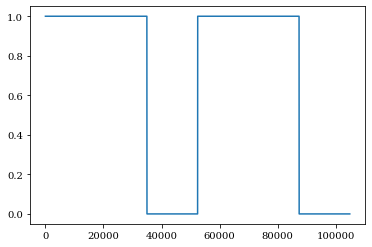

In [52]:
test_default_mask(Y_df, ds_in_test=728 * 24, is_test=False)#728?
mask_df = get_default_mask_df(Y_df=Y_df, ds_in_test=728 * 24, is_test=False)

plt.plot(mask_df.sample_mask.values)

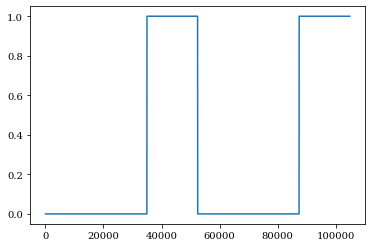

In [53]:
mask_df = get_default_mask_df(Y_df=Y_df, ds_in_test=728 * 24, is_test=True)

plt.plot(mask_df.sample_mask.values)

In [55]:
#Test for datasets with more than two time series

from neuralforecast.data.datasets.tourism import Tourism, TourismInfo

meta = TourismInfo['Yearly']
Y_df, *_ = Tourism.load(directory='data', group=meta.name)
test_default_mask(Y_df, ds_in_test=meta.horizon, is_test=False)
test_default_mask(Y_df, ds_in_test=meta.horizon, is_test=True)

100%|██████████| 356k/356k [00:00<00:00, 1.11MiB/s]
INFO:neuralforecast.data.datasets.utils:Successfully downloaded 27-3-Athanasopoulos1.zip, 356334, bytes.
INFO:neuralforecast.data.datasets.utils:Decompressing zip file...
INFO:neuralforecast.data.datasets.utils:Successfully decompressed data/tourism/datasets/27-3-Athanasopoulos1.zip


In [56]:
Y_df.head()

,unique_id,ds,y
0,Y1,1979-12-31,25092.2284
1,Y1,1980-12-31,24271.5134
2,Y1,1981-12-31,25828.9883
3,Y1,1982-12-31,27697.5047
4,Y1,1983-12-31,27956.2276


In [59]:
Y_df.unique_id.nunique()

518

## Dataset tests

In [60]:
def instantiate_datasets(Y_df, S_df, X_df, f_cols=None, 
                         ds_in_test=0, is_test=False,
                         input_size=15,
                         output_size=1,
                         complete_windows=False,
                         sample_freq=1):
    mask_df = get_default_mask_df(Y_df=Y_df, ds_in_test=ds_in_test, is_test=is_test)
                        
    ts_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=S_df, X_df=X_df, f_cols=f_cols, 
                                   mask_df=mask_df,
                                   input_size=input_size,
                                   output_size=output_size,
                                   complete_windows=complete_windows)
    
    wd_dataset = WindowsDataset(Y_df=Y_df, S_df=S_df, X_df=X_df, f_cols=f_cols, 
                                   mask_df=mask_df,
                                   input_size=input_size,
                                   output_size=output_size,
                                   sample_freq=sample_freq,
                                   complete_windows=complete_windows)
    
    return ts_dataset, wd_dataset, mask_df

In [61]:
def test_dataset_attrs(Y_df, S_df, X_df, f_cols, ds_in_test, is_test):
    # This set catches mistmaches between Y_df and ts_tensor
    ts_dataset, wd_dataset, mask_df = instantiate_datasets(Y_df=Y_df, S_df=S_df, X_df=X_df, 
                                           f_cols=f_cols, ds_in_test=ds_in_test, 
                                           is_test=is_test)
    
    dfs = [Y_df, X_df, mask_df]
    dfs = [df.set_index(['unique_id', 'ds']) for df in dfs]
    dfs = dfs[0].join(dfs[1:])
    
    #Temporal variables
    for dataset in [ts_dataset, wd_dataset]:
        for idx_ts, (uid, df) in enumerate(dfs.groupby('unique_id')):
            len_ts = dataset.len_series[idx_ts]

            for col in dataset.t_cols:
                ts = t.Tensor(df[col].values)
                idx_tensor = dataset.t_cols.index(col)
                ts_tensor = dataset.ts_tensor[idx_ts, idx_tensor, -len_ts:]

                assert np.array_equal(ts, ts_tensor), (
                    f'Error with time series {uid} and col {col} (idx={idx_ts}).'
                )

        #Static variables
        for idx_ts, (uid, df) in enumerate(S_df.groupby('unique_id')):
            len_ts = dataset.len_series[idx_ts]

            s = df[dataset.s_cols].values
            s_matrix = dataset.s_matrix[[idx_ts]]

            assert np.array_equal(s, s_matrix), (
                f'Error with static variables for time series {uid} (idx={idx_ts})'
            )

In [62]:
def test_get_f_idxs(Y_df, S_df, X_df, f_cols, ds_in_test, is_test, expected_f_idxs):
    ts_dataset, wd_dataset, mask_df = instantiate_datasets(Y_df=Y_df, S_df=S_df, X_df=X_df, 
                                           f_cols=f_cols, ds_in_test=ds_in_test, 
                                           is_test=is_test)
    
    assert ts_dataset._get_f_idxs(f_cols) == expected_f_idxs
    assert wd_dataset._get_f_idxs(f_cols) == expected_f_idxs

In [63]:
def test_ts_tensor(Y_df, S_df, X_df, f_cols, ds_in_test, is_test, 
                   input_size, output_size, ts_idxs):
    ts_dataset, wd_dataset, mask_df = instantiate_datasets(Y_df=Y_df, S_df=S_df, X_df=X_df, 
                                           f_cols=f_cols, ds_in_test=ds_in_test, 
                                           is_test=is_test,
                                           input_size=input_size,
                                           output_size=output_size)
    
    for dataset in [ts_dataset, wd_dataset]:
        min_len = min(dataset.len_series)
        dfs = [Y_df, X_df, mask_df]
        dfs = [df.set_index(['unique_id', 'ds']) for df in dfs]
        dfs = dfs[0].join(dfs[1:])
        
        # This process only works for balanced datasets.
        
        n_ts = Y_df['unique_id'].unique().shape[0]
        n_x = dfs.columns.shape[0]
        idxs = range(n_ts) if ts_idxs is None else ts_idxs

        e_filtered_tensor = t.Tensor(dfs.values.reshape((n_ts, min_len, n_x))[idxs])
        e_filtered_tensor = np.swapaxes(e_filtered_tensor, 2, 1)
        filtered_tensor = dataset.ts_tensor[ts_idxs, :, dataset.first_ds:]

        assert np.array_equal(e_filtered_tensor, filtered_tensor), (
            "Expected and dataset filtered_tensor are different. Check."
        )

In [64]:
# Test for not sorted datasets with more than two time series


from neuralforecast.data.utils import create_synthetic_tsdata

Y_df, X_df, S_df = create_synthetic_tsdata()
ds_in_test = 2
is_test = False
f_cols = ['future_1']
expected_f_idxs = [2]
len_sample_chunks = 15 #only for ESRNN

In [65]:
Y_df.head()

,unique_id,ds,y
0,uid_1,2020-12-31,1
0,uid_2,2020-12-30,1
1,uid_2,2020-12-31,2
0,uid_3,2020-12-29,1
1,uid_3,2020-12-30,2


In [67]:
X_df.head()

,unique_id,ds,day_of_week,future_1
0,uid_1,2020-12-31,3,2
0,uid_2,2020-12-30,2,2
1,uid_2,2020-12-31,3,3
0,uid_3,2020-12-29,1,2
1,uid_3,2020-12-30,2,3


In [69]:
S_df.head() #每一个unique_id的类别

,unique_id,id_ts
0,uid_1,0
0,uid_2,11
0,uid_3,22
0,uid_4,33
0,uid_5,44


In [68]:
test_dataset_attrs(Y_df, S_df, X_df, f_cols=f_cols, ds_in_test=ds_in_test, is_test=is_test)

 This causes leakage during train and incorrect forecast dates.


In [70]:
test_get_f_idxs(Y_df, S_df, X_df, f_cols=f_cols, ds_in_test=ds_in_test, is_test=is_test, 
                expected_f_idxs=expected_f_idxs)

 This causes leakage during train and incorrect forecast dates.
